The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 150)

In [3]:
## https://www.kaggle.com/krukmat/more-analysis-of-variables
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

# my laptop's capacity is not enough to train the model on full data set so let's get back to 2 kk obs


In [4]:
%%time
training=pd.read_csv('train.csv', dtype=dtypes, nrows=1000000)

Wall time: 1min 3s


In [5]:
%%time
testing=pd.read_csv('test.csv', dtype=dtypes)

Wall time: 8min 31s


In [6]:
MachIdent=testing['MachineIdentifier']

# Exploratory data analysis

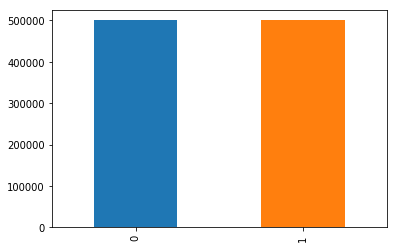

In [7]:
# Inspecting "HasDetections" variable

# there are almost equal number of positive and negative instanses
training['HasDetections'].value_counts().plot(kind='bar')

In [7]:
training['MachineIdentifier'].nunique()

4000000

In [8]:
%%time
# training.corr()['HasDetections'].sort_values()

Wall time: 0 ns


In [9]:
## percentage of missing values in a given columns
# nine variables have more than 30 percent of missing value in them
# the rest have only less than 6% of missing value so it would be possible to impute 
# something in their places 
%time training.isnull().mean().sort_values(ascending=False)

Wall time: 2.69 s


PuaMode                                              0.999739
Census_ProcessorClass                                0.995899
DefaultBrowsersIdentifier                            0.951377
Census_IsFlightingInternal                           0.830380
Census_InternalBatteryType                           0.710267
Census_ThresholdOptIn                                0.634991
Census_IsWIMBootEnabled                              0.634140
SmartScreen                                          0.356216
OrganizationIdentifier                               0.308393
SMode                                                0.060260
CityIdentifier                                       0.036546
Wdft_IsGamer                                         0.033973
Wdft_RegionIdentifier                                0.033973
Census_InternalBatteryNumberOfCharges                0.030130
Census_FirmwareManufacturerIdentifier                0.020476
Census_IsFlightsDisabled                             0.017970
Census_F

In [10]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [11]:
binary_variables = [c for c in training.columns if training[c].nunique() == 2]
binary_variables

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_ThresholdOptIn',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

In [12]:
# borrowed from some kernel, that person reckons that those columns are "trully numerical"
true_numerical_columns = [ 
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges']

In [13]:
categorical_columns = [c for c in training.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [10]:
def frequency_encoding(variable):
    t = training[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

# Binary varibles 

# DefaultBrowsersIdentifier

In [274]:
# this variables has mostly missing variables so it isn't useful 
training['DefaultBrowsersIdentifier'].isnull().sum()

951697

In [275]:
testing['DefaultBrowsersIdentifier'].notnull().sum()

307119

# IsSxsPassiveMode

In [47]:
training['IsSxsPassiveMode'].value_counts(dropna=False)/training.shape[0]

0    0.982668
1    0.017332
Name: IsSxsPassiveMode, dtype: float64

In [48]:
testing['IsSxsPassiveMode'].value_counts(dropna=False)/testing.shape[0]

0    0.984132
1    0.015868
Name: IsSxsPassiveMode, dtype: float64

In [49]:
training.groupby('IsSxsPassiveMode')['HasDetections'].value_counts()

IsSxsPassiveMode  HasDetections
0                 1                493362
                  0                489306
1                 0                 10881
                  1                  6451
Name: HasDetections, dtype: int64

# HasTpm

In [50]:
training['HasTpm'].head()

0    1
1    1
2    1
3    1
4    1
Name: HasTpm, dtype: int8

In [51]:
# it has low variance, and is not very predictive 
training['HasTpm'].value_counts(dropna=False)/training.shape[0]

1    0.987898
0    0.012102
Name: HasTpm, dtype: float64

In [52]:
testing['HasTpm'].value_counts(dropna=False)/testing.shape[0]

1    0.991717
0    0.008283
Name: HasTpm, dtype: float64

In [53]:
training.groupby('HasTpm')['HasDetections'].value_counts()

HasTpm  HasDetections
0       0                  6346
        1                  5756
1       1                494057
        0                493841
Name: HasDetections, dtype: int64

# AutoSampleOptIn

In [54]:
# This varible has very low variance
training['AutoSampleOptIn'].value_counts()

0    999969
1        31
Name: AutoSampleOptIn, dtype: int64

# SMode

In [55]:
# low variance
training['SMode'].value_counts(dropna=False)

 0.0    939687
NaN      59902
 1.0       411
Name: SMode, dtype: int64

In [56]:
training.groupby('SMode')['HasDetections'].value_counts()

SMode  HasDetections
0.0    1                474823
       0                464864
1.0    0                   345
       1                    66
Name: HasDetections, dtype: int64

In [57]:
training[training['SMode'].isnull()]['HasDetections'].value_counts()

0    34978
1    24924
Name: HasDetections, dtype: int64

In [58]:
testing['SMode'].value_counts(dropna=False)

NaN     5831272
 0.0    2015562
 1.0       6419
Name: SMode, dtype: int64

In [59]:
SMode_train=pd.get_dummies(training[['SMode']],columns=['SMode'], prefix='SM', dummy_na=True)
SMode_test=pd.get_dummies(testing[['SMode']],columns=['SMode'], prefix='SM', dummy_na=True)

In [60]:
SMode_train.drop(columns=['SM_1.0'],inplace=True)
SMode_test.drop(columns=['SM_1.0'],inplace=True)

In [61]:
# del training['SMode'], testing['SMode']

#  Firewall

In [62]:
training['Firewall'].value_counts()

1.0    968266
0.0     21394
Name: Firewall, dtype: int64

In [63]:
training[training['Firewall'].isnull()]['HasDetections'].value_counts()

0    5213
1    5127
Name: HasDetections, dtype: int64

In [64]:
# This variable is not predictable at all
training.groupby('Firewall')['HasDetections'].value_counts()

Firewall  HasDetections
0.0       0                 10809
          1                 10585
1.0       0                484165
          1                484101
Name: HasDetections, dtype: int64

# Census_HasOpticalDiskDrive

In [65]:
training['Census_HasOpticalDiskDrive'].value_counts()

0    922871
1     77129
Name: Census_HasOpticalDiskDrive, dtype: int64

In [66]:
training.groupby('Census_HasOpticalDiskDrive')['HasDetections'].value_counts()

Census_HasOpticalDiskDrive  HasDetections
0                           0                464221
                            1                458650
1                           1                 41163
                            0                 35966
Name: HasDetections, dtype: int64

In [67]:
training['Census_HasOpticalDiskDrive'].isnull().sum()

0

# Census_IsPortableOperatingSystem

In [297]:
# there is too little variable in this variable
training['Census_IsPortableOperatingSystem'].value_counts()

0    999410
1       590
Name: Census_IsPortableOperatingSystem, dtype: int64

In [298]:
training.groupby('Census_IsPortableOperatingSystem')['HasDetections'].value_counts()

Census_IsPortableOperatingSystem  HasDetections
0                                 0                499926
                                  1                499484
1                                 1                   329
                                  0                   261
Name: HasDetections, dtype: int64

# Census_IsFlightingInternal

In [299]:
# 83% of missing values
training['Census_IsFlightingInternal'].isnull().sum()

830157

## Multiple category variables

# AvSigVersion

In [16]:
training.groupby('AvSigVersion')['HasDetections'].value_counts()

AvSigVersion  HasDetections
1.221.14.0    0                50
              1                48
1.225.1459.0  0                 4
1.225.1590.0  0                 5
              1                 3
1.225.191.0   0                 1
1.225.2575.0  0                 6
1.227.1509.0  0                 1
1.227.2034.0  0                 1
1.229.1054.0  0                 6
              1                 2
1.231.1493.0  0                 3
              1                 1
1.231.1796.0  1                 2
              0                 1
1.231.195.0   1                 2
1.233.1137.0  1                 2
              0                 1
1.233.119.0   1                 1
1.233.1332.0  0                 1
              1                 1
1.233.2039.0  0                 1
              1                 1
1.233.2114.0  1                11
              0                 9
1.233.216.0   0                 2
              1                 1
1.233.2306.0  0                 1
              1     

In [7]:
training['AvSigVersion'].value_counts().shape

(7353,)

In [8]:
testing['AvSigVersion'].value_counts().shape

(9357,)

In [11]:
freq_enc_dict1 = frequency_encoding('AvSigVersion')
training['AvSigVersion1'] = training['AvSigVersion'].map(lambda x: freq_enc_dict1.get(x, -1)).astype(int)
testing['AvSigVersion1'] = testing['AvSigVersion'].map(lambda x: freq_enc_dict1.get(x, -1)).astype(int)

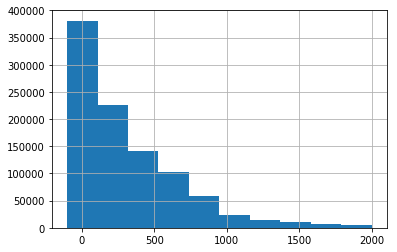

In [15]:
training['AvSigVersion1'].hist(bins=10,range=(-100, 2000))

In [17]:
inter=set(training['AvSigVersion'].unique()).intersection(set(testing['AvSigVersion'].unique()))

# Numerical Features

# Census_InternalPrimaryDiagonalDisplaySizeInInches   

In [71]:
training['Census_InternalPrimaryDiagonalDisplaySizeInInches'].head()

0    18.906250
1    13.898438
2    21.500000
3    18.500000
4    14.000000
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float16

In [72]:
np.log(training['Census_InternalPrimaryDiagonalDisplaySizeInInches']).corr(training['HasDetections'])

0.054269689599803182

In [73]:
med_DD=training['Census_InternalPrimaryDiagonalDisplaySizeInInches'].median()
training['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(value=med_DD, inplace=True)
testing['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(value=med_DD,inplace=True)

In [74]:
training['log_DDS']=np.log1p(training['Census_InternalPrimaryDiagonalDisplaySizeInInches'])
testing['log_DDS']=np.log1p(testing['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

In [75]:
# del training['Census_InternalPrimaryDiagonalDisplaySizeInInches'], testing['Census_InternalPrimaryDiagonalDisplaySizeInInches']

# Census_InternalPrimaryDisplayResolutionHorizontal

In [76]:
training['Census_InternalPrimaryDisplayResolutionHorizontal'].head()

0    1440.0
1    1366.0
2    1920.0
3    1366.0
4    1366.0
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: float16

In [77]:
med_DRH=training['Census_InternalPrimaryDisplayResolutionHorizontal'].median()
training['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(value=med_DRH,inplace=True)
testing['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(value=med_DRH,inplace=True)

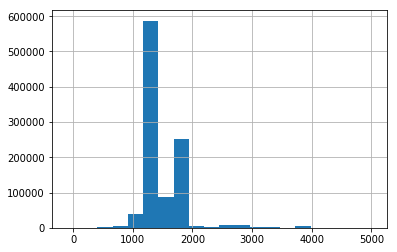

In [78]:
training['Census_InternalPrimaryDisplayResolutionHorizontal'].hist(bins=20,range=(-100,5000))

In [79]:
training['log_DRH']=np.log1p(training['Census_InternalPrimaryDisplayResolutionHorizontal']+1)
testing['log_DRH']=np.log1p(testing['Census_InternalPrimaryDisplayResolutionHorizontal']+1)

In [80]:
# del training['Census_InternalPrimaryDisplayResolutionHorizontal'], testing['Census_InternalPrimaryDisplayResolutionHorizontal']

# Census_InternalPrimaryDisplayResolutionVertical
    

In [81]:
(training['Census_InternalPrimaryDisplayResolutionVertical'].value_counts().head()/training.shape[0]).cumsum()

768.0     0.557520
1080.0    0.798591
900.0     0.871948
800.0     0.901260
1024.0    0.922282
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: float64

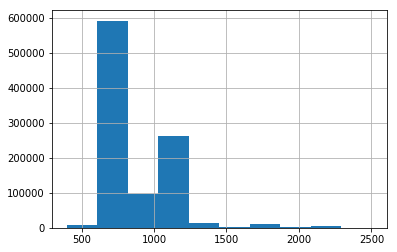

In [82]:
training['Census_InternalPrimaryDisplayResolutionVertical'].hist(bins=10,range=(400,2500))

In [83]:
training['Census_InternalPrimaryDisplayResolutionVertical'].isnull().sum()

5372

In [84]:
training[training['Census_InternalPrimaryDisplayResolutionVertical']<0]['Census_InternalPrimaryDisplayResolutionVertical']

86641    -1.0
174431   -1.0
245597   -1.0
340295   -1.0
403759   -1.0
439181   -1.0
540172   -1.0
627565   -1.0
695468   -1.0
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: float16

In [85]:
np.log1p(training['Census_InternalPrimaryDisplayResolutionVertical']+1).corr(training['HasDetections'])

0.020050654472508193

In [86]:
med_DRV=training['Census_InternalPrimaryDisplayResolutionVertical'].median()
training['Census_InternalPrimaryDisplayResolutionVertical'].fillna(value=med_DRV,inplace=True)
testing['Census_InternalPrimaryDisplayResolutionVertical'].fillna(value=med_DRV,inplace=True)

In [87]:
training['log_DRV']=np.log1p(training['Census_InternalPrimaryDisplayResolutionVertical']+1)
testing['log_DRV']=np.log1p(testing['Census_InternalPrimaryDisplayResolutionVertical']+1)

In [322]:
# del training['Census_InternalPrimaryDisplayResolutionVertical'], testing['Census_InternalPrimaryDisplayResolutionVertical']

# Census_OSVersion

In [323]:
training['Census_OSVersion'].value_counts(dropna=False)[:10]/training.shape[0]

10.0.17134.228     0.158286
10.0.17134.165     0.100795
10.0.16299.431     0.061221
10.0.17134.285     0.052383
10.0.16299.547     0.039173
10.0.17134.112     0.038941
10.0.16299.371     0.036495
10.0.17134.191     0.025629
10.0.14393.2189    0.025064
10.0.16299.611     0.024226
Name: Census_OSVersion, dtype: float64

In [324]:
testing['Census_OSVersion'].value_counts(dropna=False)[:10]/testing.shape[0]

10.0.17134.345      0.175413
10.0.17134.285      0.085273
10.0.17134.407      0.066230
10.0.17134.286      0.046579
10.0.16299.431      0.036161
10.0.17134.112      0.028913
10.0.10240.17443    0.024947
10.0.16299.371      0.024931
10.0.14393.2189     0.024371
10.0.10586.1176     0.021000
Name: Census_OSVersion, dtype: float64

In [325]:
len(set(training['Census_OSVersion'].unique()).intersection(set(testing['Census_OSVersion'].unique())))

314

In [326]:
freq_enc_dict4 = frequency_encoding('Census_OSVersion')
training['Census_OSVersion1'] = training['Census_OSVersion'].map(lambda x: freq_enc_dict4.get(x, -1)).astype(int)
testing['Census_OSVersion1'] = testing['Census_OSVersion'].map(lambda x: freq_enc_dict4.get(x, -1)).astype(int)

# OsVer

In [9]:
training.groupby('OsVer')['HasDetections'].value_counts()

OsVer       HasDetections
10.0.0.0    0                483925
            1                483682
6.1.1.0     0                  5407
            1                  5104
6.3.0.0     1                 10966
            0                 10803
10.0.1.44   0                     1
6.1.0.0     0                    28
            1                    28
6.1.3.0     1                     2
6.3.1.0     1                     2
10.0.3.0    1                     9
            0                     6
10.0.1.0    1                    11
            0                     6
10.0.32.72  0                     1
10.0.2.0    0                     2
            1                     2
10.0.5.18   0                     1
10.0.0.1    0                     1
10.0.21.0   0                     1
6.3.3.0     0                     1
            1                     1
10.0.4.0    1                     1
10.0.80.0   1                     1
10.0.7.0    0                     2
            1                     1
10

In [13]:
testing['SkuEdition'].value_counts()

Home               4513114
Pro                3195422
Invalid              48013
Education            36874
Enterprise           31700
Enterprise LTSB      20132
Cloud                 5639
Server                2359
Name: SkuEdition, dtype: int64

# SkuEdition

In [31]:
training.groupby('SkuEdition')['HasDetections'].value_counts()

SkuEdition       HasDetections
Cloud            0                   376
                 1                   218
Education        1                  2378
                 0                  2158
Enterprise       1                  2023
                 0                  1923
Enterprise LTSB  1                  1240
                 0                  1046
Home             0                314286
                 1                304088
Invalid          0                  4701
                 1                  4175
Pro              1                185582
                 0                175416
Server           0                   281
                 1                   109
Name: HasDetections, dtype: int64

In [32]:
training['SkuEdition1']=training['SkuEdition'].replace(training['SkuEdition'].value_counts().index[2:], np.nan)

testing['SkuEdition1']=testing['SkuEdition'].replace(testing['SkuEdition'].value_counts().index[2:], np.nan)

In [ ]:
training['SkuEdition1']

In [96]:
SkuE_train=pd.get_dummies(training[['SkuEdition1']],columns=['SkuEdition1'],prefix='SkuE')
SkuE_test=pd.get_dummies(testing[['SkuEdition1']],columns=['SkuEdition1'],prefix='SkuE')

In [103]:
SkuE_train.drop(columns=['SkuE_Cloud','SkuE_Education','SkuE_Enterprise','SkuE_Enterprise LTSB','SkuE_Invalid','SkuE_Server'],inplace=True)
SkuE_test.drop(columns=['SkuE_Cloud','SkuE_Education','SkuE_Enterprise','SkuE_Enterprise LTSB','SkuE_Invalid','SkuE_Server'],inplace=True)

In [105]:
SkuE_test.head()

,SkuE_Home,SkuE_Pro
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


# Antivirus software

## AVProductStatesIdentifier 

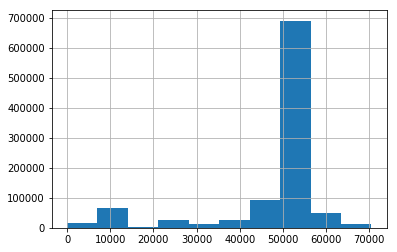

In [106]:
training['AVProductStatesIdentifier'].hist()

In [107]:
(training['AVProductStatesIdentifier'].value_counts().head(4)/training.shape[0]).cumsum()

53447.0    0.652936
7945.0     0.705928
47238.0    0.742489
62773.0    0.772358
Name: AVProductStatesIdentifier, dtype: float64

In [108]:
(testing['AVProductStatesIdentifier'].value_counts(dropna=False).head(4)/testing.shape[0]).cumsum()

53447.0    0.701445
47238.0    0.739831
7945.0     0.777447
62773.0    0.809959
Name: AVProductStatesIdentifier, dtype: float64

In [109]:
%%time
training['AVProductStatesIdentifier']=training['AVProductStatesIdentifier'].replace(training['AVProductStatesIdentifier'].value_counts().index[4:], np.nan)

testing['AVProductStatesIdentifier']=testing['AVProductStatesIdentifier'].replace(testing['AVProductStatesIdentifier'].value_counts().index[4:], np.nan)

Wall time: 5min 3s


In [110]:
# training.groupby('AVProductStatesIdentifier')['HasDetections'].value_counts()

In [111]:
training[training['AVProductStatesIdentifier'].isnull()]['HasDetections'].value_counts()

0    138034
1     89608
Name: HasDetections, dtype: int64

In [112]:
AVPSI_train=pd.get_dummies(training[['AVProductStatesIdentifier']],columns=['AVProductStatesIdentifier'], prefix='AVPSI', dummy_na=True)
AVPSI_test=pd.get_dummies(testing[['AVProductStatesIdentifier']],columns=['AVProductStatesIdentifier'], prefix='AVPSI', dummy_na=True)

In [113]:
# freq_enc_dict6 = frequency_encoding('AVProductStatesIdentifier')
# training['AVProductStatesIdentifier'] = training['AVProductStatesIdentifier'].map(lambda x: freq_enc_dict6.get(x, -1)).astype(int)
# testing['AVProductStatesIdentifier'] = testing['AVProductStatesIdentifier'].map(lambda x: freq_enc_dict6.get(x, -1)).astype(int)

In [114]:
#  ID for the specific configuration of a user's antivirus software
training['AVProductStatesIdentifier'].describe()

count    772358.000000
mean      50271.242188
std       11709.269531
min        7945.000000
25%       53447.000000
50%       53447.000000
75%       53447.000000
max       62773.000000
Name: AVProductStatesIdentifier, dtype: float64

In [115]:
# med=training['AVProductStatesIdentifier'].median()
# training['AVProductStatesIdentifier'].fillna(value=med, inplace=True)
# testing['AVProductStatesIdentifier'].fillna(value=med, inplace=True)

In [116]:
training[['AVProductStatesIdentifier']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
AVProductStatesIdentifier    772358 non-null float32
dtypes: float32(1)
memory usage: 3.8 MB


In [117]:
# training['AVProductStatesIdentifier'].corr(training['HasDetections'])

## AVProductsEnabled

In [118]:
# it mostly have one value, very little variance 
training['AVProductsEnabled'].value_counts(dropna=False)/training.shape[0]

 1.0    0.969800
 2.0    0.022427
NaN     0.004093
 0.0    0.002963
 3.0    0.000671
 4.0    0.000045
 5.0    0.000001
Name: AVProductsEnabled, dtype: float64

In [119]:
testing['AVProductsEnabled'].value_counts(dropna=False)/testing.shape[0]

 1.0    0.975062
 2.0    0.018956
NaN     0.003026
 0.0    0.002241
 3.0    0.000661
 4.0    0.000050
 5.0    0.000002
Name: AVProductsEnabled, dtype: float64

In [120]:
training.groupby('AVProductsEnabled')['HasDetections'].value_counts()

AVProductsEnabled  HasDetections
0.0                0                  1909
                   1                  1054
1.0                1                489336
                   0                480464
2.0                0                 14783
                   1                  7644
3.0                0                   462
                   1                   209
4.0                0                    27
                   1                    18
5.0                0                     1
Name: HasDetections, dtype: int64

In [121]:
hd=training[['HasDetections']]

In [122]:
hd[training['AVProductsEnabled'].isnull()]['HasDetections'].value_counts()

0    2541
1    1552
Name: HasDetections, dtype: int64

In [123]:
training['AVProductsEnabled'].fillna(0,inplace=True)
testing['AVProductsEnabled'].fillna(0,inplace=True)

In [124]:
# freq_enc_dict2 = frequency_encoding('AVProductsEnabled')
# training['AVProductsEnabled1'] = training['AVProductsEnabled'].map(lambda x: freq_enc_dict2.get(x, -1)).astype(int)
# testing['AVProductsEnabled1'] = testing['AVProductsEnabled'].map(lambda x: freq_enc_dict2.get(x, -1)).astype(int)

In [125]:
AVPE_train=pd.get_dummies(training[['AVProductsEnabled']],columns=['AVProductsEnabled'], prefix='AVPE')
AVPE_test=pd.get_dummies(testing[['AVProductsEnabled']],columns=['AVProductsEnabled'], prefix='AVPE')

In [126]:
AVPE_train.drop(columns=['AVPE_0.0','AVPE_3.0','AVPE_4.0','AVPE_5.0'],inplace=True)
AVPE_test.drop(columns=['AVPE_0.0','AVPE_3.0','AVPE_4.0','AVPE_5.0'],inplace=True)

## AVProductsInstalled

In [127]:
# both AVProductsInstalled and AVProductsEnabled have the same number of missing values
# which might mean that those computers don't have any antivirus software installed at all,
# therfore let's fillna with 0
training['AVProductsInstalled'].value_counts(dropna=False)/training.shape[0]

 1.0    0.696094
 2.0    0.275385
 3.0    0.023400
NaN     0.004093
 4.0    0.000972
 5.0    0.000056
Name: AVProductsInstalled, dtype: float64

In [128]:
testing['AVProductsInstalled'].value_counts(dropna=False)/testing.shape[0]

 1.0    0.744864
 2.0    0.232465
 3.0    0.018808
NaN     0.003026
 4.0    0.000792
 5.0    0.000042
 6.0    0.000003
Name: AVProductsInstalled, dtype: float64

In [129]:
training.groupby('AVProductsInstalled')['HasDetections'].value_counts()/training.shape[0]

AVProductsInstalled  HasDetections
1.0                  1                0.381998
                     0                0.314096
2.0                  0                0.166267
                     1                0.109118
3.0                  0                0.016526
                     1                0.006874
4.0                  0                0.000714
                     1                0.000258
5.0                  0                0.000043
                     1                0.000013
Name: HasDetections, dtype: float64

In [130]:
hd[training['AVProductsInstalled'].isnull()]['HasDetections'].value_counts()

0    2541
1    1552
Name: HasDetections, dtype: int64

In [131]:
training['AVProductsInstalled'].fillna(0,inplace=True)
testing['AVProductsInstalled'].fillna(0,inplace=True)

In [132]:
# freq_enc_dict3 = frequency_encoding('AVProductsInstalled')
# training['AVProductsInstalled1'] = training['AVProductsInstalled'].map(lambda x: freq_enc_dict3.get(x, -1)).astype(int)
# testing['AVProductsInstalled1'] = testing['AVProductsInstalled'].map(lambda x: freq_enc_dict3.get(x, -1)).astype(int)

In [133]:
AVPI_train=pd.get_dummies(training[['AVProductsInstalled']],columns=['AVProductsInstalled'], prefix='AVPI')
AVPI_test=pd.get_dummies(testing[['AVProductsInstalled']],columns=['AVProductsInstalled'], prefix='AVPI')

In [134]:
# AVPI_train.drop(columns=['AVPI_6.0','AVPI_7.0'],inplace=True)
AVPI_test.drop(columns='AVPI_6.0',inplace=True)

In [135]:
AVPI_train.drop(columns=['AVPI_0.0','AVPI_3.0','AVPI_4.0','AVPI_5.0'],inplace=True)
# AVPI_train.drop(columns=['AVPI_0.0','AVPI_4.0','AVPI_5.0','AVPI_6.0'],inplace=True)# case of 2 mil obs
# AVPI_train.drop(columns=['AVPI_0.0','AVPI_4.0','AVPI_5.0','AVPI_6.0', 'AVPI_7.0'],inplace=True) # case of 4 mil obs
AVPI_test.drop(columns=['AVPI_0.0','AVPI_3.0','AVPI_4.0','AVPI_5.0'],inplace=True)

In [136]:
AVPI_test.head()

,AVPI_1.0,AVPI_2.0
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


## OSbuild

In [137]:
(training['OsBuild'].value_counts(dropna=False).head()/training.shape[0]).cumsum()

17134    0.438463
16299    0.719444
15063    0.807324
14393    0.888988
10586    0.935238
Name: OsBuild, dtype: float64

In [138]:
(testing['OsBuild'].value_counts().head()/testing.shape[0]).cumsum()

17134    0.495742
16299    0.711014
15063    0.789464
14393    0.862754
10586    0.909531
Name: OsBuild, dtype: float64

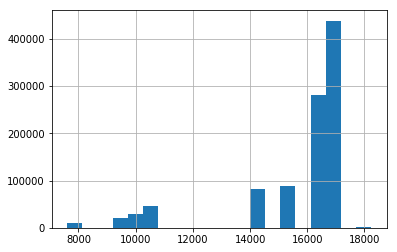

In [139]:
training['OsBuild'].hist(bins=20)

In [140]:
training['OsBuild']=training['OsBuild'].replace(training['OsBuild'].value_counts().index[4:], np.nan)

testing['OsBuild']=testing['OsBuild'].replace(testing['OsBuild'].value_counts().index[4:], np.nan)

In [141]:
training.groupby('OsBuild')['HasDetections'].value_counts()

OsBuild  HasDetections
14393.0  0                 43918
         1                 37746
15063.0  0                 45806
         1                 42074
16299.0  0                142959
         1                138022
17134.0  1                228618
         0                209845
Name: HasDetections, dtype: int64

In [142]:
OsB_train=pd.get_dummies(training[['OsBuild']],columns=['OsBuild'], prefix='OsB',dummy_na=True)
OsB_test=pd.get_dummies(testing[['OsBuild']],columns=['OsBuild'], prefix='OsB',dummy_na=True)

# OsSuite

In [19]:
training.groupby('OsSuite')['HasDetections'].value_counts()

OsSuite  HasDetections
16       1                    56
         0                    30
49       0                     1
         1                     1
144      1                     4
         0                     2
256      1                192734
         0                181978
272      0                   910
         1                   450
274      0                     4
         1                     2
305      0                    40
         1                    34
400      0                    73
         1                    20
768      0                317140
         1                306504
784      0                     9
         1                     8
Name: HasDetections, dtype: int64

In [29]:
training['OsSuite'].value_counts()

768    623644
256    374712
272      1360
400        93
16         86
305        74
784        17
274         6
144         6
49          2
Name: OsSuite, dtype: int64

In [26]:
testing['OsSuite'].value_counts()

768    4539020
256    3303044
272       9106
16         662
305        595
400        556
784        202
274         23
144         20
49          18
307          3
18           3
402          1
Name: OsSuite, dtype: int64

In [30]:
Su_train=pd.get_dummies(training[['OsSuite']],columns=['OsSuite'], prefix='Su')
Su_test=pd.get_dummies(testing[['OsSuite']],columns=['OsSuite'], prefix='Su')

In [32]:
Su_test.head()

,Su_16,Su_18,Su_49,Su_144,Su_256,Su_272,Su_274,Su_305,Su_307,Su_400,Su_402,Su_768,Su_784
0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [33]:
Su_train.drop(columns=['Su_16','Su_49','Su_144','Su_272','Su_274','Su_305','Su_400','Su_784'],inplace=True)
Su_test.drop(columns=['Su_16','Su_18','Su_49','Su_144','Su_272','Su_274','Su_305','Su_307','Su_400','Su_402','Su_784'],inplace=True)

## Census_PrimaryDiskTotalCapacity

In [143]:
(training['Census_PrimaryDiskTotalCapacity'].value_counts().head()/training.shape[0]).cumsum()

476940.0    0.319018
953869.0    0.562170
305245.0    0.615240
122104.0    0.668139
244198.0    0.718773
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

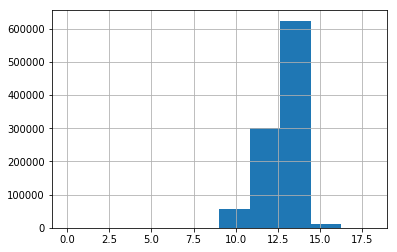

In [144]:
np.log1p(training['Census_PrimaryDiskTotalCapacity']).hist()

In [145]:
med_CPDTC=training['Census_PrimaryDiskTotalCapacity'].median()
training['Census_PrimaryDiskTotalCapacity'].fillna(value=med_CPDTC, inplace=True)
testing['Census_PrimaryDiskTotalCapacity'].fillna(value=med_CPDTC, inplace=True)

In [146]:
training['log_CPDTC']=np.log1p(training['Census_PrimaryDiskTotalCapacity'])
testing['log_CPDTC']=np.log1p(testing['Census_PrimaryDiskTotalCapacity'])

In [147]:
# del training['Census_PrimaryDiskTotalCapacity'], testing['Census_PrimaryDiskTotalCapacity']

## IsProtected

In [148]:
training['IsProtected'].value_counts(dropna=False)

 1.0    941675
 0.0     54249
NaN       4076
Name: IsProtected, dtype: int64

In [149]:
training.groupby('IsProtected')['HasDetections'].value_counts()

IsProtected  HasDetections
0.0          0                 33569
             1                 20680
1.0          1                477592
             0                464083
Name: HasDetections, dtype: int64

In [150]:
IP_train=pd.get_dummies(training[['IsProtected']],columns=['IsProtected'], prefix='IP',dummy_na=True)
IP_test=pd.get_dummies(testing[['IsProtected']],columns=['IsProtected'], prefix='IP',dummy_na=True)

In [151]:
IP_train.drop(columns=['IP_1.0','IP_nan'],inplace=True)
IP_test.drop(columns=['IP_1.0','IP_nan'],inplace=True)

In [152]:
IP_train.head()

,IP_0.0
0,0
1,0
2,0
3,0
4,0


In [374]:
# del training['IsProtected'], testing['IsProtected']

# Census_IsSecureBootEnabled

In [40]:
training.groupby('Census_IsSecureBootEnabled')['HasDetections'].value_counts()/training.shape[0]

Census_IsSecureBootEnabled  HasDetections
0                           1                0.257012
                            0                0.256067
1                           0                0.244120
                            1                0.242801
Name: HasDetections, dtype: float64

# Census_IsTouchEnabled

In [45]:
training.groupby('Census_IsTouchEnabled')['HasDetections'].value_counts()

Census_IsTouchEnabled  HasDetections
0                      1                443922
                       0                430725
1                      0                 69462
                       1                 55891
Name: HasDetections, dtype: int64

In [44]:
training['Census_IsTouchEnabled'].isnull().sum()

0

# CountryIdentifier

In [153]:
setA=set((training['CountryIdentifier'].value_counts().head(50)/training.shape[0]).cumsum().index)

In [154]:
setB=((testing['CountryIdentifier'].value_counts().head(50)/testing.shape[0]).cumsum().index)

In [155]:

len(setA.intersection(setB))

48

In [156]:
%%time
training['CountryIdentifier1']=training['CountryIdentifier'].replace(training['CountryIdentifier'].value_counts().index[50:], np.nan)

testing['CountryIdentifier1']=testing['CountryIdentifier'].replace(testing['CountryIdentifier'].value_counts().index[50:], np.nan)

Wall time: 54.4 s


In [157]:
freq_enc_dict5 = frequency_encoding('CountryIdentifier1')
training['CountryIdentifier1'] = training['CountryIdentifier1'].map(lambda x: freq_enc_dict5.get(x, -1)).astype(int)
testing['CountryIdentifier1'] = testing['CountryIdentifier1'].map(lambda x: freq_enc_dict5.get(x, -1)).astype(int)

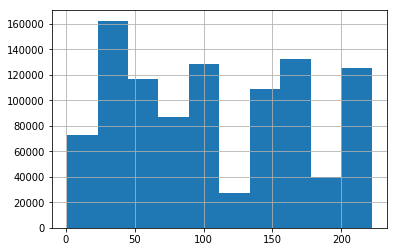

In [158]:
training['CountryIdentifier'].hist()

In [159]:
np.log(training['CountryIdentifier']).corr(training['HasDetections'])

0.0071060743205436719

# CityIdentifier

In [8]:
import category_encoders as ce

In [382]:
(training['CityIdentifier'].value_counts().head(5)/training.shape[0]).cumsum()

130775.0    0.010702
16668.0     0.020219
82373.0     0.029430
10222.0     0.037388
61668.0     0.044799
Name: CityIdentifier, dtype: float64

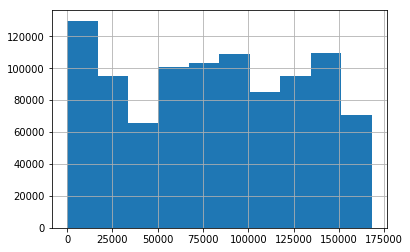

In [383]:
training['CityIdentifier'].hist()

In [9]:
# %%time
# encoder = ce.TargetEncoder(cols=['CityIdentifier'])

# encoder.fit(training[['CityIdentifier']], training['HasDetections'])
# training['CityIdentifier1'] = encoder.transform(training[['CityIdentifier']])

Wall time: 4min 52s


In [ ]:
# testing['CityIdentifier1'] = encoder.transform(testing[['CityIdentifier']])

In [385]:
# freq_enc_dict8 = frequency_encoding('CityIdentifier')
# training['CityIdentifier1'] = training['CityIdentifier'].map(lambda x: freq_enc_dict8.get(x, -1)).astype(int)
# testing['CityIdentifier1'] = testing['CityIdentifier'].map(lambda x: freq_enc_dict8.get(x, -1)).astype(int)

# OrganizationIdentifier

In [160]:
(training['OrganizationIdentifier'].value_counts(dropna=False).head()/training.shape[0]).cumsum()

 27.0    0.470461
NaN      0.779397
 18.0    0.976335
 48.0    0.983523
 50.0    0.988636
Name: OrganizationIdentifier, dtype: float64

In [161]:
(testing['OrganizationIdentifier'].value_counts(dropna=False).head()/testing.shape[0]).cumsum()

 27.0    0.459077
NaN      0.775140
 18.0    0.972813
 48.0    0.982638
 50.0    0.988477
Name: OrganizationIdentifier, dtype: float64

In [162]:
%%time
training['OrganizationIdentifier1']=training['OrganizationIdentifier'].replace(training['OrganizationIdentifier'].value_counts().index[2:], np.nan)

testing['OrganizationIdentifier1']=testing['OrganizationIdentifier'].replace(testing['OrganizationIdentifier'].value_counts().index[2:], np.nan)

Wall time: 4.84 s


In [163]:
testing['OrganizationIdentifier1'].value_counts()

27.0    3605244
18.0    1552377
Name: OrganizationIdentifier1, dtype: int64

In [164]:
training.groupby('OrganizationIdentifier1')['HasDetections'].value_counts()

OrganizationIdentifier1  HasDetections
18.0                     1                 99295
                         0                 97643
27.0                     0                236031
                         1                234430
Name: HasDetections, dtype: int64

In [165]:
training[training['OrganizationIdentifier1'].isnull()]['HasDetections'].value_counts()

0    166513
1    166088
Name: HasDetections, dtype: int64

In [166]:
OI_train=pd.get_dummies(training[['OrganizationIdentifier1']],columns=['OrganizationIdentifier1'], prefix='OI')
OI_test=pd.get_dummies(testing[['OrganizationIdentifier1']],columns=['OrganizationIdentifier1'], prefix='OI')

In [167]:
OI_train.head()

,OI_18.0,OI_27.0
0,1,0
1,1,0
2,1,0
3,0,0
4,0,0


# GeoNameIdentifier

In [8]:
training['GeoNameIdentifier'].value_counts().head()

277.0    172045
211.0     47343
53.0      46045
89.0      40414
240.0     38887
Name: GeoNameIdentifier, dtype: int64

In [10]:
training.groupby('GeoNameIdentifier', sort=False)['HasDetections'].value_counts()

GeoNameIdentifier  HasDetections
35.0               1                19687
                   0                18869
119.0              0                10167
                   1                 9984
64.0               1                 2145
                   0                 2047
117.0              1                 5386
                   0                 4593
277.0              1                88247
                   0                83798
126.0              0                11532
                   1                10652
89.0               0                21276
                   1                19138
205.0              0                 6553
                   1                 6178
138.0              0                10196
                   1                 9343
101.0              0                 3765
                   1                 3512
211.0              1                23688
                   0                23655
209.0              0                 2631
 

In [395]:
testing['GeoNameIdentifier'].value_counts().head(5)

277.0    1407739
53.0      464823
211.0     462082
89.0      303780
35.0      297959
Name: GeoNameIdentifier, dtype: int64

# LocaleEnglishNameIdentifier

In [396]:
training['LocaleEnglishNameIdentifier'].describe()

count    1000000.000000
mean          27.856237
std           65.608600
min         -127.000000
25%          -29.000000
50%           58.000000
75%           75.000000
max          127.000000
Name: LocaleEnglishNameIdentifier, dtype: float64

In [397]:
testing['LocaleEnglishNameIdentifier'].describe()

count    7.853253e+06
mean     2.681400e+01
std      6.578649e+01
min     -1.280000e+02
25%     -2.900000e+01
50%      5.600000e+01
75%      7.500000e+01
max      1.270000e+02
Name: LocaleEnglishNameIdentifier, dtype: float64

# Platform

In [168]:
training['Platform'].value_counts(dropna=False)

windows10      966030
windows8        21774
windows7        10569
windows2016      1627
Name: Platform, dtype: int64

In [169]:
training.groupby('Platform')['HasDetections'].value_counts()

Platform     HasDetections
windows10    1                483142
             0                482888
windows2016  0                  1060
             1                   567
windows7     0                  5435
             1                  5134
windows8     1                 10970
             0                 10804
Name: HasDetections, dtype: int64

In [170]:
testing['Platform'].value_counts(dropna=False)

windows10      7675480
windows8        111547
windows7         55240
windows2016      10986
Name: Platform, dtype: int64

In [171]:
Plt_train=pd.get_dummies(training[['Platform']],columns=['Platform'], prefix='Plt')
Plt_test=pd.get_dummies(testing[['Platform']],columns=['Platform'], prefix='Plt')

In [172]:
Plt_test.head()

,Plt_windows10,Plt_windows2016,Plt_windows7,Plt_windows8
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


# 'Processor'

In [173]:
training['Processor'].value_counts(dropna=False)

x64      908729
x86       91231
arm64        40
Name: Processor, dtype: int64

In [174]:
testing['Processor'].value_counts(dropna=False)

x64      7173360
x86       679682
arm64        211
Name: Processor, dtype: int64

In [175]:
training.groupby('Processor')['HasDetections'].value_counts()

Processor  HasDetections
arm64      0                    40
x64        1                464616
           0                444113
x86        0                 56034
           1                 35197
Name: HasDetections, dtype: int64

In [176]:
Proc_train=pd.get_dummies(training[['Processor']],columns=['Processor'], prefix='Pr',drop_first=True)
Proc_test=pd.get_dummies(testing[['Processor']],columns=['Processor'], prefix='Pr')

In [177]:
Proc_train.head()

,Pr_x64,Pr_x86
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [178]:
Proc_test.drop(columns='Pr_arm64', inplace=True)

## UacLuaenable 

In [179]:
# 'UacLuaenable' takes only value 1 it might not be a good predictor 
print( training['UacLuaenable'].value_counts(dropna=False) )

training.groupby('UacLuaenable')['HasDetections'].value_counts()

 1.0          992776
 0.0            5981
NaN             1218
 48.0             20
 6357062.0         2
 2.0               2
 3.0               1
Name: UacLuaenable, dtype: int64


UacLuaenable  HasDetections
0.0           1                  3013
              0                  2968
1.0           0                496640
              1                496136
2.0           0                     2
3.0           1                     1
48.0          1                    13
              0                     7
6357062.0     0                     1
              1                     1
Name: HasDetections, dtype: int64

## SmartScreen

In [180]:
training.groupby('SmartScreen')['HasDetections'].value_counts()

SmartScreen   HasDetections
Block         1                  1351
              0                  1197
ExistsNotSet  1                 94844
              0                 22721
Off           0                 10683
              1                 10335
On            1                    37
              0                    34
Prompt        0                  2035
              1                  1769
RequireAdmin  0                272118
              1                211711
Warn          1                  8795
              0                  6345
off           1                    89
              0                    59
&#x01;        0                    21
              1                    18
on            0                     8
              1                     8
&#x02;        1                    23
              0                    20
OFF           0                     1
Promt         1                     1
Name: HasDetections, dtype: int64

In [181]:
# SmartScreen variable
training['SmartScreen']=training['SmartScreen'].str.lower()
training['SmartScreen'].replace(to_replace='promt',value='prompt',inplace=True)
training['SmartScreen'].value_counts(dropna=False)

training['SmartScreen'].replace({"promt":"prompt",
                        "promprt":"prompt",
                        "00000000":"0",
                        "enabled":"on",
                        "of":"off" ,
                        "0":"off" ,
                        "deny": "off" , # just one
                        "requiredadmin":"requireadmin"},inplace=True)


In [182]:
testing['SmartScreen']=testing['SmartScreen'].str.lower()

testing['SmartScreen'].replace({"promt":"prompt",
                        "promprt":"prompt",
                        "00000000":"0",
                        "enabled":"on",
                        "of":"off" ,
                        "0":"off" ,
                        "deny": "off" , # just one
                        "requiredadmin":"requireadmin"},inplace=True)
testing['SmartScreen'].value_counts(dropna=False)

NaN             3498402
requireadmin    3413571
existsnotset     600446
off              163166
warn             125926
prompt            28890
block             21242
on                  939
&#x02;              404
&#x01;              267
Name: SmartScreen, dtype: int64

In [183]:
freq_enc_dict3 = frequency_encoding('SmartScreen')
training['SmartScreen1'] = training['SmartScreen'].map(lambda x: freq_enc_dict3.get(x, -1)).astype(int)
testing['SmartScreen1'] = testing['SmartScreen'].map(lambda x: freq_enc_dict3.get(x, -1)).astype(int)

In [184]:
SS_train=pd.get_dummies(training[['SmartScreen']],columns=['SmartScreen'], prefix='SS',dummy_na=True)
SS_test=pd.get_dummies(testing[['SmartScreen']],columns=['SmartScreen'], prefix='SS',dummy_na=True)

In [185]:
SS_train.columns

Index(['SS_&#x01;', 'SS_&#x02;', 'SS_block', 'SS_existsnotset', 'SS_off',
       'SS_on', 'SS_prompt', 'SS_requireadmin', 'SS_warn', 'SS_nan'],
      dtype='object')

In [186]:
SS_train.drop(columns=['SS_&#x01;','SS_&#x02;','SS_block','SS_off','SS_on', 'SS_prompt'], inplace=True)
SS_test.drop(columns=['SS_&#x01;','SS_&#x02;','SS_block','SS_off','SS_on', 'SS_prompt'], inplace=True)

In [187]:
# SS_train.drop(columns=['SS_&#x03;'],inplace=True)

In [188]:
# del training['SmartScreen'], testing['SmartScreen']

## Census_ProcessorCoreCount

In [12]:
%%time
training.groupby('Census_ProcessorCoreCount')['HasDetections'].value_counts()

Wall time: 287 ms


Census_ProcessorCoreCount  HasDetections
1.0                        0                  5509
                           1                  2254
2.0                        0                140013
                           1                119561
3.0                        0                   812
                           1                   691
4.0                        1                309102
                           0                299235
5.0                        0                    15
                           1                    15
6.0                        1                  4456
                           0                  3444
7.0                        0                     6
                           1                     5
8.0                        1                 53542
                           0                 43315
10.0                       0                     6
12.0                       1                  6145
                           0             

In [189]:
np.log(training['Census_ProcessorCoreCount']).corr(training['HasDetections'])

0.064177955694420447

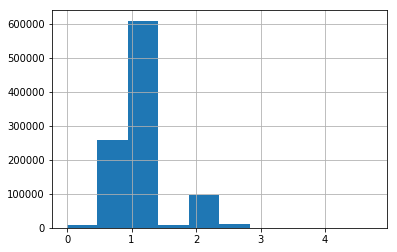

In [190]:
np.log(training['Census_ProcessorCoreCount']).hist()

In [191]:
med_CC=training['Census_ProcessorCoreCount'].median()
training['Census_ProcessorCoreCount'].fillna(med_CC,inplace=True)
testing['Census_ProcessorCoreCount'].fillna(med_CC,inplace=True)

In [192]:
training['log_CoreCount']=np.log(training['Census_ProcessorCoreCount'])
testing['log_CoreCount']=np.log(testing['Census_ProcessorCoreCount'])

In [193]:
# del training['Census_ProcessorCoreCount'], testing['Census_ProcessorCoreCount']

## Wdft_IsGamer

In [194]:
training.groupby('Wdft_IsGamer')['HasDetections'].value_counts(dropna=False)/training.shape[0]

Wdft_IsGamer  HasDetections
0.0           0                0.358422
              1                0.333613
1.0           1                0.148489
              0                0.125383
Name: HasDetections, dtype: float64

In [195]:
testing['Wdft_IsGamer'].value_counts(dropna=False)/testing.shape[0]

 0.0    0.675212
 1.0    0.286223
NaN     0.038565
Name: Wdft_IsGamer, dtype: float64

In [196]:
training[training['Wdft_IsGamer'].isnull()]['HasDetections'].value_counts()

1    17711
0    16382
Name: HasDetections, dtype: int64

In [197]:
Wdft_train=pd.get_dummies(training[['Wdft_IsGamer']],columns=['Wdft_IsGamer'], prefix='Wdft')
Wdft_test=pd.get_dummies(testing[['Wdft_IsGamer']],columns=['Wdft_IsGamer'], prefix='Wdft')

In [426]:
# del training['Wdft_IsGamer'], testing['Wdft_IsGamer']

## Census_SystemVolumeTotalCapacity
    

In [15]:
training['Census_SystemVolumeTotalCapacity'].value_counts().head()/training.shape[0]

28542.0     0.005797
926992.0    0.005637
476389.0    0.005008
953253.0    0.004637
102400.0    0.004596
Name: Census_SystemVolumeTotalCapacity, dtype: float64

In [17]:
testing['Census_SystemVolumeTotalCapacity'].value_counts().head()/testing.shape[0]

476389.0    0.007168
476324.0    0.006550
953253.0    0.006231
28542.0     0.006118
926992.0    0.005354
Name: Census_SystemVolumeTotalCapacity, dtype: float64

In [30]:
set(training['Census_SystemVolumeTotalCapacity'].unique()).intersection(set(testing['Census_SystemVolumeTotalCapacity'].unique()))

AttributeError: 'set' object has no attribute 'values'

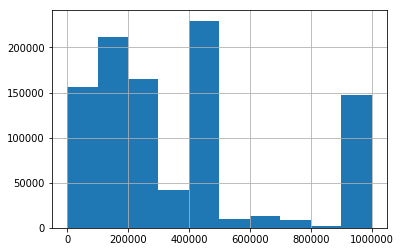

In [199]:
training['Census_SystemVolumeTotalCapacity'].hist(range=(0,1000000))

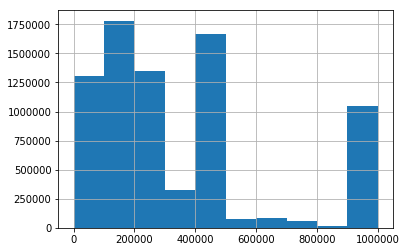

In [200]:
testing['Census_SystemVolumeTotalCapacity'].hist(range=(0,1000000))

In [201]:
med_SVTC=training['Census_SystemVolumeTotalCapacity'].median()
training['Census_SystemVolumeTotalCapacity'].fillna(value=med_SVTC,inplace=True)
testing['Census_SystemVolumeTotalCapacity'].fillna(value=med_SVTC,inplace=True)

In [202]:
training['log_CSVTC']=np.log1p(training['Census_SystemVolumeTotalCapacity'])
testing['log_CSVTC']=np.log1p(testing['Census_SystemVolumeTotalCapacity'])

In [432]:
# del training['Census_SystemVolumeTotalCapacity'], testing['Census_SystemVolumeTotalCapacity']

## IsBeta

In [203]:
# Half of the beta is malicious and the half is not 
# it seems like this variable does not predict the detection
# the results of adversarial validation and training the model suggest that IsBeta does not predict Hasdetections
training.groupby('IsBeta')['HasDetections'].value_counts()

IsBeta  HasDetections
0       0                500182
        1                499811
1       0                     5
        1                     2
Name: HasDetections, dtype: int64

## RtpStateBitfield'

In [204]:
training['RtpStateBitfield'].value_counts(dropna=False)/training.shape[0]

 7.0    0.969610
 0.0    0.021340
NaN     0.003666
 8.0    0.002544
 5.0    0.002281
 3.0    0.000367
 1.0    0.000192
Name: RtpStateBitfield, dtype: float64

In [205]:
testing['RtpStateBitfield'].value_counts(dropna=False)/testing.shape[0]

 7.0     9.701782e-01
 0.0     2.069601e-02
NaN      4.103013e-03
 8.0     2.957883e-03
 5.0     1.635628e-03
 3.0     2.446120e-04
 1.0     1.814535e-04
 35.0    3.056058e-06
 40.0    1.273358e-07
Name: RtpStateBitfield, dtype: float64

In [206]:
# value counts suggest that when RtpStateBitfield is not equal to 7 there is higher chance to be detected 
training.groupby('RtpStateBitfield')['HasDetections'].value_counts()

RtpStateBitfield  HasDetections
0.0               0                 13270
                  1                  8070
1.0               0                   113
                  1                    79
3.0               0                   249
                  1                   118
5.0               0                  1943
                  1                   338
7.0               1                487626
                  0                481984
8.0               1                  1909
                  0                   635
Name: HasDetections, dtype: int64

In [207]:
training[training['RtpStateBitfield'].isnull()]['HasDetections'].value_counts()

0    1993
1    1673
Name: HasDetections, dtype: int64

In [208]:
Rtp_train=pd.get_dummies(training[['RtpStateBitfield']],columns=['RtpStateBitfield'], prefix='Rtp')
Rtp_test=pd.get_dummies(testing[['RtpStateBitfield']],columns=['RtpStateBitfield'], prefix='Rtp')

In [209]:
Rtp_train.drop(columns=['Rtp_1.0', 'Rtp_3.0', 'Rtp_5.0'],inplace=True) # 2 mil obs
# Rtp_train.drop(columns=['Rtp_1.0', 'Rtp_3.0', 'Rtp_5.0','Rtp_35.0'],inplace=True) # 4 mil obs
Rtp_test.drop(columns=['Rtp_1.0', 'Rtp_3.0', 'Rtp_5.0', 'Rtp_35.0', 'Rtp_40.0'],inplace=True)

In [210]:
# del training['RtpStateBitfield'], testing['RtpStateBitfield']

## Census_TotalPhysicalRAM

In [211]:
training['Census_TotalPhysicalRAM'].value_counts().head(5)

4096.0     459527
8192.0     245744
2048.0     122823
16384.0     59559
6144.0      44893
Name: Census_TotalPhysicalRAM, dtype: int64

In [212]:
testing['Census_TotalPhysicalRAM'].value_counts(dropna=False).head()

4096.0     3529277
8192.0     1995041
2048.0      932422
16384.0     505916
6144.0      331597
Name: Census_TotalPhysicalRAM, dtype: int64

In [213]:
# training['Census_TotalPhysicalRAM']=training['Census_TotalPhysicalRAM'].replace(training['Census_TotalPhysicalRAM'].value_counts().index[4:], np.nan)

# testing['Census_TotalPhysicalRAM']=testing['Census_TotalPhysicalRAM'].replace(testing['Census_TotalPhysicalRAM'].value_counts().index[4:], np.nan)

In [214]:
# training.groupby('Census_TotalPhysicalRAM')['HasDetections'].value_counts().head()/training.shape[0]

In [215]:
training[training['Census_TotalPhysicalRAM'].isnull()]['HasDetections'].value_counts()/training.shape[0]

0    0.004816
1    0.004180
Name: HasDetections, dtype: float64

In [216]:
freq_enc_dict7 = frequency_encoding('Census_TotalPhysicalRAM')
training['RAM1'] = training['Census_TotalPhysicalRAM'].map(lambda x: freq_enc_dict7.get(x, -1)).astype(int)
testing['RAM1'] = testing['Census_TotalPhysicalRAM'].map(lambda x: freq_enc_dict7.get(x, -1)).astype(int)

In [217]:
# RAM_train=pd.get_dummies(training[['Census_TotalPhysicalRAM']],columns=['Census_TotalPhysicalRAM'], prefix='RAM')
# RAM_test=pd.get_dummies(testing[['Census_TotalPhysicalRAM']],columns=['Census_TotalPhysicalRAM'], prefix='RAM')

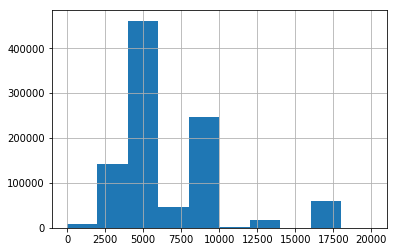

In [218]:
training['Census_TotalPhysicalRAM'].hist(bins=10, range=(0,20000) )

In [449]:
# med_Ram=training['Census_TotalPhysicalRAM'].median()
# training['Census_TotalPhysicalRAM'].fillna(value=med_Ram,inplace=True)
# testing['Census_TotalPhysicalRAM'].fillna(value=med_Ram, inplace=True)

In [450]:
# training['log_ram']=np.log(training['Census_TotalPhysicalRAM'])
# testing['log_ram']=np.log(testing['Census_TotalPhysicalRAM'])

In [451]:
# del training['Census_TotalPhysicalRAM'], testing['Census_TotalPhysicalRAM']

# Forming dataset

In [219]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [220]:
y=training['HasDetections']
X=pd.concat([training[[ 'log_CSVTC','Census_IsTouchEnabled', 'RAM1',  'CountryIdentifier1', #'CityIdentifier1', 
                       'Firewall', 'HasTpm', 'log_DDS', 'log_DRH', 'log_DRV', 'AvSigVersion1', 
                       'IsSxsPassiveMode', 'log_CoreCount', 'Census_HasOpticalDiskDrive']],
                   SkuE_train, Plt_train, OI_train, AVPSI_train, OsB_train,SS_train, AVPE_train, AVPI_train, IP_train,
             Rtp_train, Wdft_train, SMode_train, Proc_train, Su_train ], axis=1)

In [221]:
X.columns 

Index(['log_CSVTC', 'Census_IsTouchEnabled', 'RAM1', 'CountryIdentifier1',
       'Firewall', 'HasTpm', 'log_DDS', 'log_DRH', 'log_DRV', 'AvSigVersion1',
       'IsSxsPassiveMode', 'log_CoreCount', 'Census_HasOpticalDiskDrive',
       'SkuE_Home', 'SkuE_Pro', 'Plt_windows10', 'Plt_windows2016',
       'Plt_windows7', 'Plt_windows8', 'OI_18.0', 'OI_27.0', 'AVPSI_7945.0',
       'AVPSI_47238.0', 'AVPSI_53447.0', 'AVPSI_62773.0', 'AVPSI_nan',
       'OsB_14393.0', 'OsB_15063.0', 'OsB_16299.0', 'OsB_17134.0', 'OsB_nan',
       'SS_existsnotset', 'SS_requireadmin', 'SS_warn', 'SS_nan', 'AVPE_1.0',
       'AVPE_2.0', 'AVPI_1.0', 'AVPI_2.0', 'IP_0.0', 'Rtp_0.0', 'Rtp_7.0',
       'Rtp_8.0', 'Wdft_0.0', 'Wdft_1.0', 'SM_0.0', 'SM_nan', 'Pr_x64',
       'Pr_x86', 'Su_256', 'Su_768'],
      dtype='object')

In [222]:
X_test=pd.concat([testing[[ 'log_CSVTC','Census_IsTouchEnabled','RAM1',  'CountryIdentifier1', #'CityIdentifier1', 
                           'Firewall','HasTpm','log_DDS', 'log_DRH', 'log_DRV', 'AvSigVersion1',
                    'IsSxsPassiveMode',  'log_CoreCount','Census_HasOpticalDiskDrive']], 
                SkuE_test, Plt_test,OI_test,AVPSI_test, OsB_test, SS_test, AVPE_test, AVPI_test,IP_test,
                  Rtp_test, Wdft_test, SMode_test, Proc_test, Su_test],axis=1)

In [223]:
X_test.columns

Index(['log_CSVTC', 'Census_IsTouchEnabled', 'RAM1', 'CountryIdentifier1',
       'Firewall', 'HasTpm', 'log_DDS', 'log_DRH', 'log_DRV', 'AvSigVersion1',
       'IsSxsPassiveMode', 'log_CoreCount', 'Census_HasOpticalDiskDrive',
       'SkuE_Home', 'SkuE_Pro', 'Plt_windows10', 'Plt_windows2016',
       'Plt_windows7', 'Plt_windows8', 'OI_18.0', 'OI_27.0', 'AVPSI_7945.0',
       'AVPSI_47238.0', 'AVPSI_53447.0', 'AVPSI_62773.0', 'AVPSI_nan',
       'OsB_14393.0', 'OsB_15063.0', 'OsB_16299.0', 'OsB_17134.0', 'OsB_nan',
       'SS_existsnotset', 'SS_requireadmin', 'SS_warn', 'SS_nan', 'AVPE_1.0',
       'AVPE_2.0', 'AVPI_1.0', 'AVPI_2.0', 'IP_0.0', 'Rtp_0.0', 'Rtp_7.0',
       'Rtp_8.0', 'Wdft_0.0', 'Wdft_1.0', 'SM_0.0', 'SM_nan', 'Pr_x64',
       'Pr_x86', 'Su_256', 'Su_768'],
      dtype='object')

In [224]:
X.shape, X_test.shape

((1000000, 51), (7853253, 51))

In [230]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=22)

In [458]:
del training,testing

# Adversarial validation

In [225]:
new_X_test=X_test.iloc[:1000000,:]

In [226]:
new_X_train=X

In [227]:
new_X_test.shape, new_X_train.shape

((1000000, 51), (1000000, 51))

In [228]:
new_X_train['target']=1
new_X_test['target']=0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [229]:
new_data=pd.concat([new_X_train,new_X_test], axis=0)

In [230]:
target=new_data['target']

In [231]:
del new_data['target'], new_X_train, new_X_test

In [232]:
new_train, new_val, target_train, target_val = train_test_split(new_data, target, 
                                                               test_size=0.3, random_state=22)

In [233]:
%%time
param = {'num_leaves': [200],
         'min_data_in_leaf': [60], 
         'objective':'binary',
         'max_depth': [10],
         'learning_rate': [0.1],
         "min_child_samples": [20],
         "boosting": "gbdt",
         "feature_fraction": [0.8],
         "bagging_freq": [1],
         "bagging_fraction": [0.8] ,
         "bagging_seed": [17],
         "metric": 'auc',
         "lambda_l1": [0.1],
         "verbosity": [-1],
         "n_jobs":[-1]}

new_train = lgb.Dataset(new_train.values, label=target_train)
new_val = lgb.Dataset(new_val.values, label=target_val)

num_round = 500
clf = lgb.train(param, new_train, num_round, valid_sets = [new_train, new_val],
                verbose_eval=10, early_stopping_rounds = 25)


Training until validation scores don't improve for 25 rounds.
[10]	training's auc: 0.970363	valid_1's auc: 0.970053
[20]	training's auc: 0.971371	valid_1's auc: 0.97097
[30]	training's auc: 0.971948	valid_1's auc: 0.971397
[40]	training's auc: 0.972531	valid_1's auc: 0.971791
[50]	training's auc: 0.973038	valid_1's auc: 0.972111
[60]	training's auc: 0.973526	valid_1's auc: 0.972417
[70]	training's auc: 0.973846	valid_1's auc: 0.972529
[80]	training's auc: 0.974133	valid_1's auc: 0.97268
[90]	training's auc: 0.974508	valid_1's auc: 0.972845
[100]	training's auc: 0.974869	valid_1's auc: 0.973032
[110]	training's auc: 0.97516	valid_1's auc: 0.973116
[120]	training's auc: 0.975394	valid_1's auc: 0.973157
[130]	training's auc: 0.975736	valid_1's auc: 0.973289
[140]	training's auc: 0.975981	valid_1's auc: 0.973318
[150]	training's auc: 0.976184	valid_1's auc: 0.973326
[160]	training's auc: 0.976408	valid_1's auc: 0.973349
[170]	training's auc: 0.97664	valid_1's auc: 0.97337
[180]	training's 

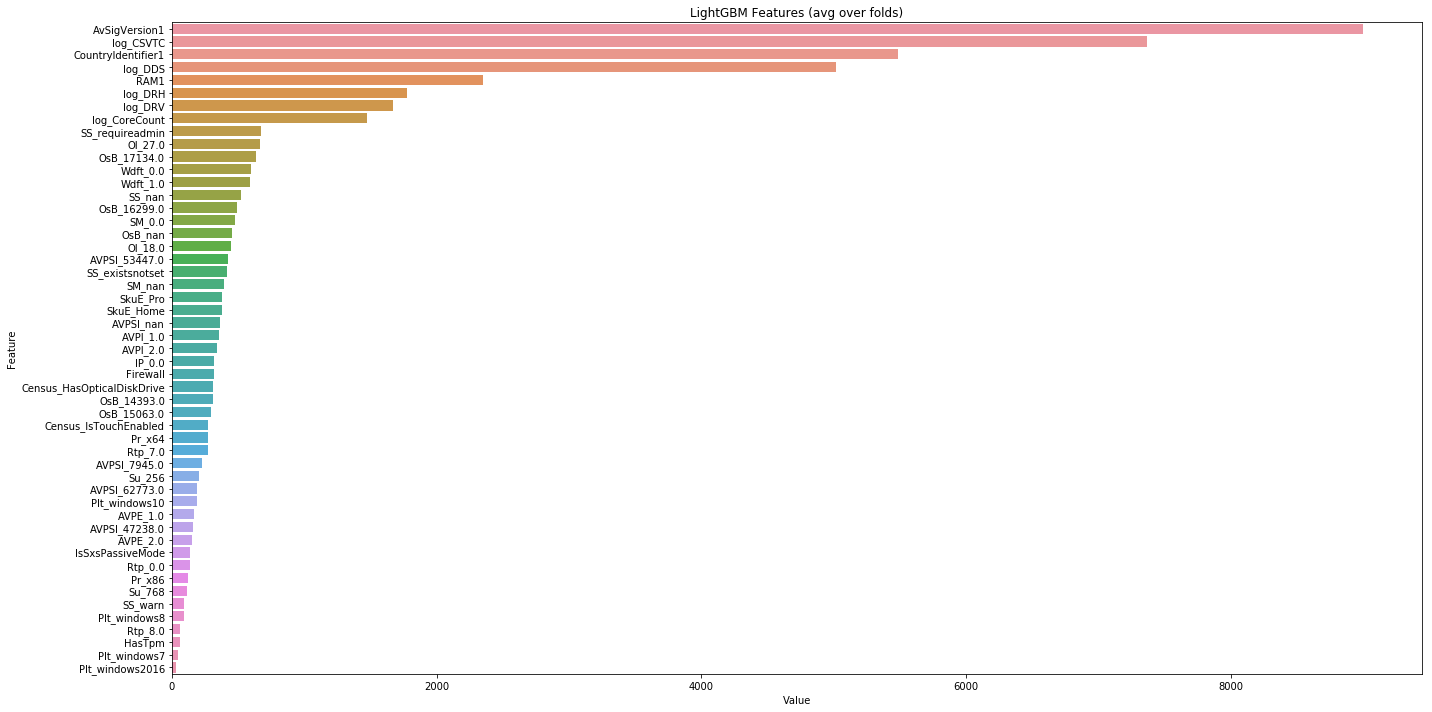

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),X.columns), reverse=True), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [235]:
pred_valid=clf.predict(X.drop(columns='target'))

In [236]:
i=pred_valid.argsort()

In [237]:
X['p'] = pred_valid
X['HasDetections']=y
X_sorted = X.iloc[i]

In [238]:
X_sorted.shape

(1000000, 54)

In [239]:
val_size = 800000

train = X_sorted.iloc[:val_size]
val = X_sorted.iloc[val_size:]

In [240]:
train.drop(columns='p',inplace=True)
val.drop(columns='p',inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [241]:
train.shape

(800000, 53)

In [242]:
y_train=train['HasDetections']
y_val=val['HasDetections']

In [243]:
train.drop(columns=['target','HasDetections'],inplace=True)
val.drop(columns=['target','HasDetections'],inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [244]:
del X_sorted, new_data, new_train, new_val

# Training the model

In [245]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train, test_size=0.3, random_state=22)

In [246]:
param_lgb = {'num_leaves':[50],
             'n_estimators':[500],
             'boosting_type':['gbdt'],
             'max_depth': [7],
             'learning_rate': [0.1],
             "boosting": ["gbdt"],
             "feature_fraction": [0.8],
             "bagging_freq": [1],
             "bagging_fraction": [0.8] ,
             "bagging_seed": [11],
             "metric": ['auc'],
             "lambda_l1": [0.2],
             }

lightclf=LGBMClassifier( random_state=22, objective='binary')

In [ ]:
%%time
# clf2 = RandomForestClassifier(n_estimators=5,max_depth=20, random_state=22, criterion='gini',n_jobs=-1).fit(X_train, y_train)
clf2=GridSearchCV(estimator=lightclf, param_grid=param_lgb, cv= 10, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

In [ ]:
%%time
# predicting probabilities for the test set
pred2=clf2.predict_proba(X_test)[:,1]

In [ ]:
clf2.best_estimator_

In [ ]:
clf2.score

In [ ]:
pred_valid=clf2.predict_proba(X_valid)[:,1]

In [ ]:
clf2.score(X_valid, y_valid)

In [ ]:
features = X_train.columns
importances = clf2.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
roc_auc_score(y_train, clf2.predict_proba(X_train)[:,1])

In [ ]:
roc_auc_score(y_valid, pred_valid)

# Writing the dataframe into the csv file

In [504]:
# sub=testing[['MachineIdentifier']]
sub=pd.DataFrame(MachIdent)


In [505]:
pred2.shape

(7853253,)

In [506]:
sub['HasDetections']=pred2

In [507]:
sub.shape

(7853253, 2)

In [508]:
sub.to_csv('submission49.csv', index=False)